In [1]:
# %% [markdown]
# # Ethiopian E-commerce Recommender - Training Notebook
# 
# This notebook contains the complete training pipeline for the Ethiopian E-commerce Recommendation System.

# %% [markdown]
# ## 1. Import Required Libraries

# %%
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import yaml
import warnings
from datetime import datetime

# Add src directory to path
sys.path.append('../src')

# Import custom modules
from data_preprocessing import EthiopianProductPreprocessor
from model_training import EthiopianRecommenderModel

# Suppress warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# %% [markdown]
# ## 2. Load Configuration

# %%
# Load configuration
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("📋 Configuration loaded:")
print(f"Project: {config['project']['name']}")
print(f"Dataset: {config['data']['raw_path']}")
print(f"Text columns: {config['features']['text_columns']}")



📋 Configuration loaded:
Project: Ethiopian E-commerce Product Recommender
Dataset: ../data/raw/ethiopian_products_10k.csv
Text columns: ['name', 'description', 'description_amharic', 'category', 'subcategory', 'brand']


📊 Loading raw dataset for exploration...
✅ Loaded 10,000 products

📈 Dataset Info:
Shape: (10000, 21)
Columns: ['product_id', 'name', 'name_amharic', 'description', 'description_amharic', 'category', 'subcategory', 'price', 'currency', 'brand', 'location', 'delivery_available', 'rating', 'stock_status', 'stock_quantity', 'weight_kg', 'dimensions', 'warranty_months', 'seller_name', 'seller_rating', 'tags']

👀 First 5 rows:


,product_id,name,name_amharic,description,description_amharic,category,subcategory,price,currency,brand,location,delivery_available,rating,stock_status,stock_quantity,weight_kg,dimensions,warranty_months,seller_name,seller_rating,tags
0,ETP00001,Pantene Makeup Premium,Pantene Makeup,High quality makeup from Ethiopia. Coach nice ...,ከፍተኛ ጥራት ያለው ኢትዮጵያዊ makeup. ይህ ምርት ለእርስዎ ተስማሚ ነው።,Beauty & Personal Care,Makeup,3400,ETB,Pantene,Asosa,Yes,3.9,In Stock,302,46.07,171x83x69 cm,0,Pantene Shop,3.3,"Beauty & Personal Care,Makeup,Asosa,Pantene,Et..."
1,ETP00002,Ethio Herbal Fragrances Deluxe,Ethio Herbal Fragrances,Best quality fragrances sourced locally. Few d...,ከፍተኛ ጥራት ያለው ኢትዮጵያዊ fragrances. ይህ ምርት ለእርስዎ ተ...,Beauty & Personal Care,Fragrances,8600,ETB,Ethio Herbal,Mekelle,No,4.1,In Stock,274,38.39,9x28x17 cm,3,Ethio Herbal Hub,3.9,"Beauty & Personal Care,Fragrances,Mekelle,Ethi..."
2,ETP00003,Tibeb Athletics Watches Standard,Tibeb Athletics Watches,Premium watches made with Ethiopian craftsmans...,እውነተኛ ኢትዮጵያዊ watches። ጥራቱ የተረጋገጠ ነው።,Fashion,Watches,12900,ETB,Tibeb Athletics,Dire Dawa,No,3.5,In Stock,64,36.84,179x40x35 cm,6,Tibeb Athletics Hub,4.2,"Fashion,Watches,Dire Dawa,Tibeb Athletics,Ethi..."
3,ETP00004,Auto Addis Car Care Deluxe,Auto Addis Car Care,High quality car care from Ethiopia. Power fol...,እውነተኛ ኢትዮጵያዊ car care። ጥራቱ የተረጋገጠ ነው።,Automotive,Car Care,58100,ETB,Auto Addis,Mekelle,Yes,4.7,In Stock,453,46.17,91x177x8 cm,6,Auto Addis Shop,3.5,"Automotive,Car Care,Mekelle,Auto Addis,Ethiopi..."
4,ETP00005,Traditional Ethiopian Tea,ኢትዮጵያዊ ቡና Tea,Authentic Ethiopian tea. See nothing ability e...,ከፍተኛ ጥራት ያለው ኢትዮጵያዊ tea. ይህ ምርት ለእርስዎ ተስማሚ ነው።,Food & Beverages,Tea,3700,ETB,Ethio Coffee,Bahir Dar,No,3.3,In Stock,290,43.15,165x91x14 cm,24,Ethio Coffee Store,4.2,"Food & Beverages,Tea,Bahir Dar,Ethio Coffee,Et..."



📊 Basic Statistics:
Price range: 50 - 149,600 ETB
Average price: 21,126.07 ETB
Average rating: 4.00/5.0

📦 Category Distribution:


category
Health                    1073
Fashion                   1048
Beauty & Personal Care    1012
Sports                     998
Home & Kitchen             997
Baby & Kids                994
Books & Stationery         974
Electronics                971
Food & Beverages           968
Automotive                 965
Name: count, dtype: int64

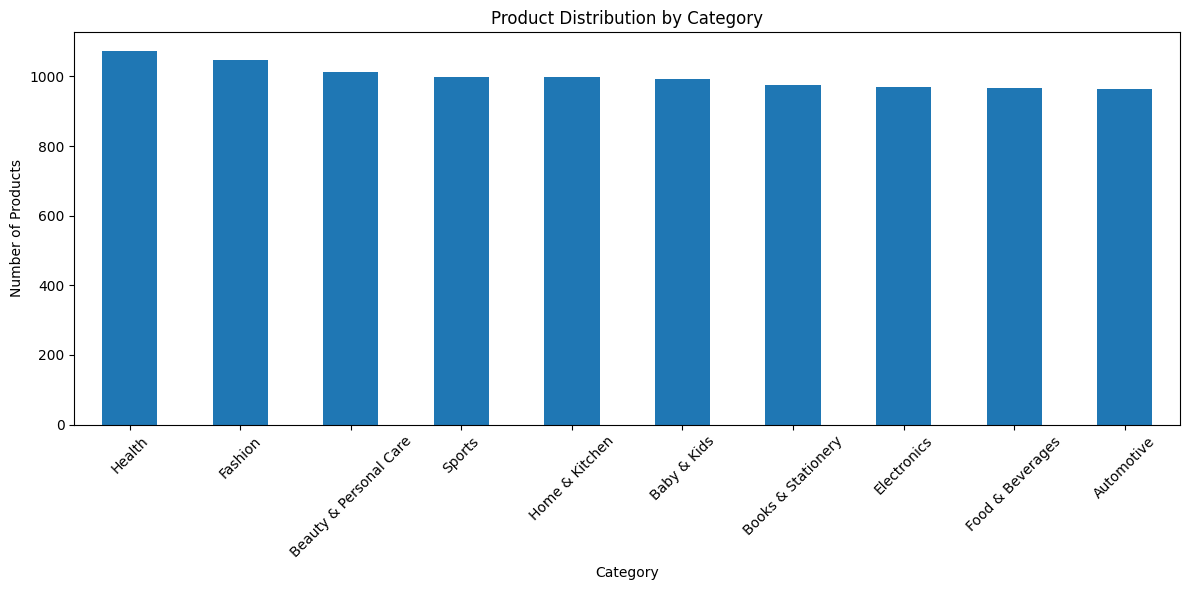


🚚 Delivery Availability:


delivery_available
Yes    7472
No     2528
Name: count, dtype: int64

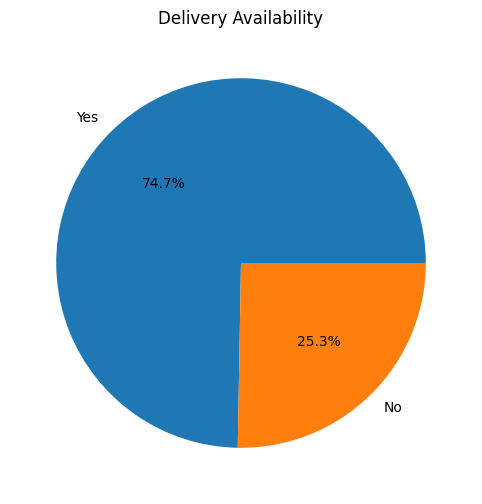


📍 Top Locations:


location
Addis Ababa    895
Gondar         871
Harar          864
Asosa          843
Hawassa        842
Bahir Dar      841
Mekelle        832
Dire Dawa      829
Jijiga         824
Adama          810
Name: count, dtype: int64

In [3]:
# %% [markdown]
# ## 3. Data Exploration

# %%
# Load raw data for exploration
print("📊 Loading raw dataset for exploration...")
raw_data_path = config['data']['raw_path']

if not os.path.exists(raw_data_path):
    print(f"❌ Dataset not found at: {raw_data_path}")
    print("Please generate the dataset first using generate_dataset.py")
else:
    df_raw = pd.read_csv(raw_data_path)
    print(f"✅ Loaded {len(df_raw):,} products")
    
    # Display basic info
    print("\n📈 Dataset Info:")
    print(f"Shape: {df_raw.shape}")
    print(f"Columns: {df_raw.columns.tolist()}")
    
    # Display first few rows
    print("\n👀 First 5 rows:")
    display(df_raw.head())
    
    # Basic statistics
    print("\n📊 Basic Statistics:")
    if 'price' in df_raw.columns:
        print(f"Price range: {df_raw['price'].min():,} - {df_raw['price'].max():,} ETB")
        print(f"Average price: {df_raw['price'].mean():,.2f} ETB")
    
    if 'rating' in df_raw.columns:
        print(f"Average rating: {df_raw['rating'].mean():.2f}/5.0")
    
    if 'category' in df_raw.columns:
        print(f"\n📦 Category Distribution:")
        category_counts = df_raw['category'].value_counts()
        display(category_counts)
        
        # Plot category distribution
        plt.figure(figsize=(12, 6))
        category_counts.plot(kind='bar')
        plt.title('Product Distribution by Category')
        plt.xlabel('Category')
        plt.ylabel('Number of Products')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    if 'delivery_available' in df_raw.columns:
        print(f"\n🚚 Delivery Availability:")
        delivery_counts = df_raw['delivery_available'].value_counts()
        display(delivery_counts)
        
        # Plot delivery availability
        plt.figure(figsize=(8, 6))
        delivery_counts.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Delivery Availability')
        plt.ylabel('')
        plt.show()
    
    if 'location' in df_raw.columns:
        print(f"\n📍 Top Locations:")
        location_counts = df_raw['location'].value_counts().head(10)
        display(location_counts)


In [4]:
# %% [markdown]
# ## 4. Data Preprocessing

# %%
print("🔧 Starting Data Preprocessing...")
preprocessor = EthiopianProductPreprocessor('../config.yaml')

# Load data
df = preprocessor.load_data()
print(f"📥 Raw data loaded: {len(df):,} products")

# Preprocess data
print("\n⚙️ Preprocessing data...")
df_processed = preprocessor.preprocess_data(df)
print(f"✅ Data preprocessed: {len(df_processed):,} products remaining")

# Save processed data
preprocessor.save_processed_data(df_processed)
print(f"💾 Processed data saved to: {config['data']['processed_path']}")

# Display processed data info
print("\n📋 Processed Data Info:")
print(f"Shape: {df_processed.shape}")
print(f"Columns: {df_processed.columns.tolist()}")

# Show sample of processed data
print("\n👀 Sample of Processed Data (5 rows):")
sample_columns = ['product_id', 'name', 'category', 'price', 'rating', 'location', 'delivery_available']
if all(col in df_processed.columns for col in sample_columns):
    display(df_processed[sample_columns].head())
else:
    # Show available columns
    available_cols = [col for col in sample_columns if col in df_processed.columns]
    display(df_processed[available_cols].head() if available_cols else df_processed.head())

# Show combined features sample
print("\n🔤 Combined Features Sample (first 3 products):")
for i, features in enumerate(df_processed['combined_features'].head(3)):
    print(f"Product {i+1}: {features[:200]}...")


🔧 Starting Data Preprocessing...
Loaded 10000 products from dataset
📥 Raw data loaded: 10,000 products

⚙️ Preprocessing data...
Preprocessed 9676 products
✅ Data preprocessed: 9,676 products remaining
Saved processed data to ../data/processed/processed_products.pkl
💾 Processed data saved to: ../data/processed/processed_products.pkl

📋 Processed Data Info:
Shape: (9676, 28)
Columns: ['product_id', 'name', 'name_amharic', 'description', 'description_amharic', 'category', 'subcategory', 'price', 'currency', 'brand', 'location', 'delivery_available', 'rating', 'stock_status', 'stock_quantity', 'weight_kg', 'dimensions', 'warranty_months', 'seller_name', 'seller_rating', 'tags', 'name_cleaned', 'description_cleaned', 'description_amharic_cleaned', 'category_cleaned', 'subcategory_cleaned', 'brand_cleaned', 'combined_features']

👀 Sample of Processed Data (5 rows):


,product_id,name,category,price,rating,location,delivery_available
0,ETP00001,Pantene Makeup Premium,Beauty & Personal Care,3400,3.9,Asosa,Yes
1,ETP00002,Ethio Herbal Fragrances Deluxe,Beauty & Personal Care,8600,4.1,Mekelle,No
2,ETP00003,Tibeb Athletics Watches Standard,Fashion,12900,3.5,Dire Dawa,No
3,ETP00004,Auto Addis Car Care Deluxe,Automotive,58100,4.7,Mekelle,Yes
4,ETP00005,Traditional Ethiopian Tea,Food & Beverages,3700,3.3,Bahir Dar,No



🔤 Combined Features Sample (first 3 products):
Product 1: pantene makeup premium high quality makeup from ethiopia  coach nice clear suddenly  ከፍተኛ ጥራት ያለው ኢትዮጵያዊ makeup  ይህ ምርት ለእርስዎ ተስማሚ ነው። beauty   personal care makeup pantene...
Product 2: ethio herbal fragrances deluxe best quality fragrances sourced locally  few design center argue several  ከፍተኛ ጥራት ያለው ኢትዮጵያዊ fragrances  ይህ ምርት ለእርስዎ ተስማሚ ነው። beauty   personal care fragrances ethio h...
Product 3: tibeb athletics watches standard premium watches made with ethiopian craftsmanship  consider provide yeah  እውነተኛ ኢትዮጵያዊ watches። ጥራቱ የተረጋገጠ ነው። fashion watches tibeb athletics...


In [5]:

# %% [markdown]
# ## 5. Model Training

# %%
print("🤖 Starting Model Training...")

# Initialize and train model
model = EthiopianRecommenderModel('../config.yaml')
print("\n⚙️ Training TF-IDF model...")
model.train()

# Save the model
print("\n💾 Saving model...")
model.save_model()
print("✅ Model saved successfully")

# Display model information
print("\n📊 Model Information:")
print(f"Number of products in model: {len(model.df):,}")
print(f"TF-IDF matrix shape: {model.tfidf_matrix.shape}")
print(f"Vocabulary size: {len(model.tfidf.vocabulary_):,}")


🤖 Starting Model Training...

⚙️ Training TF-IDF model...
Loaded processed data from ../data/processed/processed_products.pkl
Training TF-IDF model...
Computing similarity matrix...
Model trained on 9676 products
TF-IDF matrix shape: (9676, 5000)

💾 Saving model...
Model saved successfully
✅ Model saved successfully

📊 Model Information:
Number of products in model: 9,676
TF-IDF matrix shape: (9676, 5000)
Vocabulary size: 5,000


In [6]:
# %% [markdown]
# ## 6. Test Recommendations

# %%
print("🧪 Testing Recommendations...")

# Get some sample product IDs from different categories
sample_products = {}
if 'category' in model.df.columns:
    for category in ['Electronics', 'Food & Beverages', 'Fashion'][:3]:
        category_products = model.df[model.df['category'] == category]
        if len(category_products) > 0:
            sample_products[category] = category_products.iloc[0]['product_id']

# Test recommendations for each sample product
for category, product_id in sample_products.items():
    print(f"\n🔍 Recommendations for {category} product ({product_id}):")
    
    try:
        # Get product details
        product_name = model.df[model.df['product_id'] == product_id].iloc[0]['name']
        print(f"   Product: {product_name}")
        
        # Get recommendations
        recommendations = model.get_recommendations(
            product_id=product_id,
            top_n=3,
            user_location='Addis Ababa',
            filter_delivery=True
        )
        
        if recommendations:
            for i, rec in enumerate(recommendations, 1):
                print(f"   {i}. {rec['name'][:60]}...")
                print(f"      Price: {rec['price']:,} ETB | Rating: {rec['rating']} | Similarity: {rec['similarity_score']:.3f}")
                print(f"      Delivery: {rec['delivery_available']} | Location: {rec['location']}")
        else:
            print("   No recommendations found")
            
    except Exception as e:
        print(f"   Error: {e}")


🧪 Testing Recommendations...

🔍 Recommendations for Electronics product (ETP00017):
   Product: Huawei Watches Premium
   1. Nile Decor Cleaning Deluxe...
      Price: 3,700.0 ETB | Rating: 3.5 | Similarity: 0.798
      Delivery: Yes | Location: Bahir Dar
   2. Nile Decor Cleaning Deluxe...
      Price: 36,800.0 ETB | Rating: 3.8 | Similarity: 0.796
      Delivery: Yes | Location: Bahir Dar

🔍 Recommendations for Food & Beverages product (ETP00005):
   Product: Traditional Ethiopian Tea
   1. Traditional Ethiopian Tea...
      Price: 3,400.0 ETB | Rating: 4.8 | Similarity: 0.789
      Delivery: Yes | Location: Jimma
   2. Ethio Coffee Ethiopian Tea...
      Price: 1,900.0 ETB | Rating: 4.0 | Similarity: 0.786
      Delivery: Yes | Location: Gondar
   3. Traditional Ethiopian Tea...
      Price: 8,000.0 ETB | Rating: 3.4 | Similarity: 0.750
      Delivery: Yes | Location: Arba Minch

🔍 Recommendations for Fashion product (ETP00003):
   Product: Tibeb Athletics Watches Standard
   1. Tib

In [7]:
# %% [markdown]
# ## 7. Advanced Testing
from sklearn.metrics.pairwise import cosine_similarity

# %%
print("🔬 Advanced Testing...")

# Test 1: Search-based recommendations (OPTIMIZED VERSION)
print("\n🔎 Search-based Recommendations (Optimized):")
search_queries = ['smartphone', 'coffee', 'traditional dress']

for query in search_queries:
    print(f"\nSearch: '{query}'")
    
    # OPTIMIZED: Transform search text and compute similarities efficiently
    search_vector = model.tfidf.transform([query])
    
    # Instead of using the full similarity matrix, compute dot product directly
    # This is faster: search_vector * tfidf_matrix^T
    similarities = cosine_similarity(search_vector, model.tfidf_matrix).flatten()
    
    # Get top 3 similar products
    top_indices = similarities.argsort()[-3:][::-1]
    
    # Display results with progress
    for i, idx in enumerate(top_indices):
        product = model.df.iloc[idx]
        similarity = similarities[idx]
        print(f"  {i+1}. {product['name'][:50]}...")
        print(f"     Similarity: {similarity:.3f}")
        print(f"     Category: {product.get('category', 'N/A')}")
        print(f"     Price: {product.get('price', 'N/A'):,} ETB")

# Test 2: Test with filters (OPTIMIZED VERSION)
print("\n" + "="*50)
print("⚙️ Testing with Filters (Fast Test):")
print("="*50)

# Use a smaller subset for testing
test_sample_size = 100  # Test with 100 products instead of all
test_products = model.df.sample(min(test_sample_size, len(model.df)), random_state=42)

print(f"\nTesting with sample of {len(test_products)} products...")

# Track statistics
delivery_stats = {
    'with_filter': {'total': 0, 'counts': []},
    'without_filter': {'total': 0, 'counts': []}
}

# Test a few representative products
test_cases = [
    {'product_id': test_products.iloc[0]['product_id'], 'name': test_products.iloc[0]['name']},
    {'product_id': test_products.iloc[50]['product_id'], 'name': test_products.iloc[50]['name']},
    {'product_id': test_products.iloc[99]['product_id'], 'name': test_products.iloc[99]['name']},
]

print(f"\nTesting 3 representative products:")
for i, test_case in enumerate(test_cases, 1):
    print(f"\n{i}. Testing: {test_case['name'][:40]}...")
    
    # With delivery filter
    try:
        recs_with_filter = model.get_recommendations(
            product_id=test_case['product_id'],
            top_n=3,  # Reduced for speed
            user_location='Addis Ababa',
            filter_delivery=True
        )
        delivery_stats['with_filter']['counts'].append(len(recs_with_filter))
        print(f"   With delivery filter: {len(recs_with_filter)} recommendations")
    except Exception as e:
        print(f"   Error with filter: {e}")
    
    # Without delivery filter
    try:
        recs_without_filter = model.get_recommendations(
            product_id=test_case['product_id'],
            top_n=3,  # Reduced for speed
            user_location='Addis Ababa',
            filter_delivery=False
        )
        delivery_stats['without_filter']['counts'].append(len(recs_without_filter))
        print(f"   Without delivery filter: {len(recs_without_filter)} recommendations")
    except Exception as e:
        print(f"   Error without filter: {e}")

# Calculate and display statistics
print("\n" + "-"*50)
print("📊 Filter Test Statistics:")
print("-"*50)

if delivery_stats['with_filter']['counts']:
    avg_with_filter = np.mean(delivery_stats['with_filter']['counts'])
    print(f"Average recommendations WITH delivery filter: {avg_with_filter:.1f}")
    
if delivery_stats['without_filter']['counts']:
    avg_without_filter = np.mean(delivery_stats['without_filter']['counts'])
    print(f"Average recommendations WITHOUT delivery filter: {avg_without_filter:.1f}")
    
    if avg_without_filter > 0:
        filter_impact = ((avg_without_filter - avg_with_filter) / avg_without_filter) * 100
        print(f"Delivery filter reduces recommendations by: {filter_impact:.1f}%")

# Test 3: Performance Benchmark
print("\n" + "="*50)
print("⏱️ Performance Benchmark:")
print("="*50)

import time

# Test recommendation speed
test_product_id = test_products.iloc[0]['product_id']
n_trials = 5
times = []

print(f"\nTesting recommendation speed ({n_trials} trials)...")
for i in range(n_trials):
    start_time = time.time()
    recommendations = model.get_recommendations(
        product_id=test_product_id,
        top_n=5,
        user_location='Addis Ababa',
        filter_delivery=True
    )
    end_time = time.time()
    elapsed = end_time - start_time
    times.append(elapsed)
    print(f"  Trial {i+1}: {elapsed:.3f} seconds")

print(f"\n⏱️ Average time per recommendation: {np.mean(times):.3f} seconds")
print(f"⏱️ Fastest time: {np.min(times):.3f} seconds")
print(f"⏱️ Slowest time: {np.max(times):.3f} seconds")


🔬 Advanced Testing...

🔎 Search-based Recommendations (Optimized):

Search: 'smartphone'
  1. MediCare Medical Equipment Standard...
     Similarity: 0.000
     Category: Health
     Price: 4,700 ETB
  2. Happy Child Feeding Standard...
     Similarity: 0.000
     Category: Baby & Kids
     Price: 12,200 ETB
  3. Green Farms Beverages Standard...
     Similarity: 0.000
     Category: Food & Beverages
     Price: 6,100 ETB

Search: 'coffee'
  1. Ethio Coffee Kaffa Coffee...
     Similarity: 0.716
     Category: Food & Beverages
     Price: 4,400 ETB
  2. Ethio Coffee Kaffa Coffee...
     Similarity: 0.707
     Category: Food & Beverages
     Price: 7,000 ETB
  3. Ethio Coffee Limu Coffee...
     Similarity: 0.690
     Category: Food & Beverages
     Price: 6,600 ETB

Search: 'traditional dress'
  1. Awraja Traditional Dress...
     Similarity: 0.336
     Category: Fashion
     Price: 10,200 ETB
  2. Awraja Traditional Dress...
     Similarity: 0.285
     Category: Fashion
     Price: 17

In [8]:
# %% [markdown]
# ## 8. Model Evaluation

# %%
print("📈 Model Evaluation...")

# Calculate some basic metrics
print("\n📊 Basic Model Metrics:")

# 1. Coverage: How many products get recommended
all_products = set(model.df['product_id'])
recommended_products = set()

# Sample 100 products to check coverage
sample_size = min(100, len(model.df))
sample_ids = model.df.sample(sample_size, random_state=42)['product_id'].tolist()

for pid in sample_ids:
    try:
        recs = model.get_recommendations(pid, top_n=5)
        for rec in recs:
            recommended_products.add(rec['product_id'])
    except:
        continue

coverage = len(recommended_products) / len(all_products) * 100
print(f"1. Catalog Coverage: {coverage:.1f}% of products appear in recommendations")


📈 Model Evaluation...

📊 Basic Model Metrics:
1. Catalog Coverage: 4.9% of products appear in recommendations



2. Similarity Score Analysis:
   Average similarity: 0.782
   Min similarity: 0.582
   Max similarity: 0.882


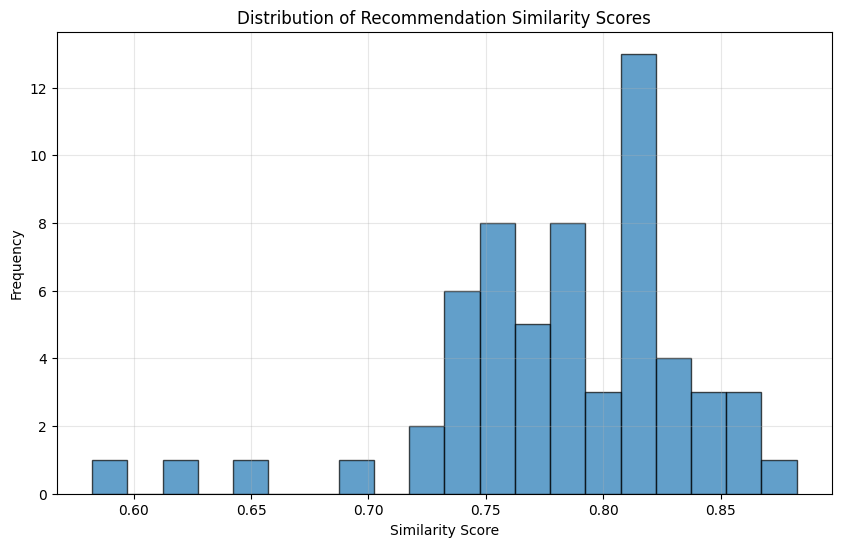


3. Category Coherence:
   Beauty & Personal Care: 100.0% of recommendations are in same category
   Fashion: 100.0% of recommendations are in same category
   Automotive: 100.0% of recommendations are in same category
   Food & Beverages: 100.0% of recommendations are in same category
   Health: 100.0% of recommendations are in same category


In [9]:
# 2. Average similarity score
print("\n2. Similarity Score Analysis:")
similarity_scores = []
for pid in sample_ids[:20]:  # Check first 20 for speed
    try:
        recs = model.get_recommendations(pid, top_n=3)
        for rec in recs:
            similarity_scores.append(rec['similarity_score'])
    except:
        continue

if similarity_scores:
    print(f"   Average similarity: {np.mean(similarity_scores):.3f}")
    print(f"   Min similarity: {np.min(similarity_scores):.3f}")
    print(f"   Max similarity: {np.max(similarity_scores):.3f}")
    
    # Plot similarity distribution
    plt.figure(figsize=(10, 6))
    plt.hist(similarity_scores, bins=20, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Recommendation Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

# 3. Category coherence
print("\n3. Category Coherence:")
if 'category' in model.df.columns:
    category_coherence = {}
    
    for category in model.df['category'].unique()[:5]:  # Check first 5 categories
        category_products = model.df[model.df['category'] == category]
        if len(category_products) > 1:
            sample_product = category_products.iloc[0]['product_id']
            recs = model.get_recommendations(sample_product, top_n=5)
            
            same_category_count = sum(1 for rec in recs if rec.get('category') == category)
            coherence = same_category_count / len(recs) * 100 if recs else 0
            
            category_coherence[category] = coherence
            print(f"   {category}: {coherence:.1f}% of recommendations are in same category")


In [10]:
# %% [markdown]
# ## 9. Save Training Report

# %%
print("📝 Generating Training Report...")

# Create training report
report = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': {
        'raw_size': len(df) if 'df' in locals() else 0,
        'processed_size': len(model.df) if model.df is not None else 0,
        'categories': model.df['category'].nunique() if model.df is not None and 'category' in model.df.columns else 0,
        'average_price': model.df['price'].mean() if model.df is not None and 'price' in model.df.columns else 0,
        'average_rating': model.df['rating'].mean() if model.df is not None and 'rating' in model.df.columns else 0,
    },
    'model': {
        'tfidf_features': model.tfidf_matrix.shape[1] if model.tfidf_matrix is not None else 0,
        'vocabulary_size': len(model.tfidf.vocabulary_) if model.tfidf is not None else 0,
        'similarity_matrix_shape': model.similarity_matrix.shape if model.similarity_matrix is not None else (0, 0),
    },
    'performance': {
        'coverage_percentage': coverage,
        'average_similarity': np.mean(similarity_scores) if similarity_scores else 0,
    }
}

# Save report to file
report_path = '../reports/training_report.json'
os.makedirs('../reports', exist_ok=True)

import json
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"✅ Training report saved to: {report_path}")

# Display report
print("\n📋 Training Report Summary:")
print("=" * 50)
print(f"Dataset: {report['dataset']['processed_size']:,} products")
print(f"Categories: {report['dataset']['categories']}")
print(f"Average Price: {report['dataset']['average_price']:,.2f} ETB")
print(f"Average Rating: {report['dataset']['average_rating']:.2f}/5.0")
print(f"TF-IDF Features: {report['model']['tfidf_features']:,}")
print(f"Catalog Coverage: {report['performance']['coverage_percentage']:.1f}%")

📝 Generating Training Report...
✅ Training report saved to: ../reports/training_report.json

📋 Training Report Summary:
Dataset: 9,676 products
Categories: 10
Average Price: 17,673.58 ETB
Average Rating: 4.00/5.0
TF-IDF Features: 5,000
Catalog Coverage: 4.9%


In [11]:
# %% [markdown]
# ## 10. Quick Demo

# %%
print("🚀 Quick Demo Interface")

# Simple interactive demo
def interactive_demo():
    print("\n" + "=" * 50)
    print("INTERACTIVE DEMO")
    print("=" * 50)
    
    # Show sample products
    print("\n📦 Sample Products:")
    sample_products = model.df.sample(5, random_state=42)[['product_id', 'name', 'category', 'price']]
    for idx, row in sample_products.iterrows():
        print(f"{row['product_id']}: {row['name'][:40]}... ({row['category']}) - {row['price']:,} ETB")
    
    while True:
        print("\n" + "-" * 50)
        print("Options:")
        print("1. Get recommendations for a product ID")
        print("2. Search for products")
        print("3. Exit")
        
        choice = input("\nEnter your choice (1-3): ").strip()
        
        if choice == '1':
            product_id = input("Enter product ID (e.g., ETP00001): ").strip()
            if product_id in model.df['product_id'].values:
                top_n = int(input("Number of recommendations (default 5): ") or "5")
                location = input("Your location (default Addis Ababa): ").strip() or "Addis Ababa"
                filter_delivery = input("Filter by delivery? (y/n, default y): ").strip().lower() != 'n'
                
                print(f"\n🔍 Recommendations for {product_id}:")
                product_name = model.df[model.df['product_id'] == product_id].iloc[0]['name']
                print(f"Product: {product_name}")
                
                recommendations = model.get_recommendations(
                    product_id=product_id,
                    top_n=top_n,
                    user_location=location,
                    filter_delivery=filter_delivery
                )
                
                if recommendations:
                    for i, rec in enumerate(recommendations, 1):
                        print(f"\n{i}. {rec['name']}")
                        print(f"   Price: {rec['price']:,} ETB | Rating: {rec['rating']:.1f}")
                        print(f"   Similarity: {rec['similarity_score']:.3f}")
                        print(f"   Delivery: {rec['delivery_available']} | Location: {rec['location']}")
                        print(f"   Category: {rec.get('category', 'N/A')}")
                else:
                    print("No recommendations found")
            else:
                print(f"Product ID {product_id} not found")
                
        elif choice == '2':
            search_text = input("Enter search text: ").strip()
            top_n = int(input("Number of results (default 5): ") or "5")
            
            print(f"\n🔍 Search results for '{search_text}':")
            
            # Simple search
            search_results = []
            for idx, row in model.df.iterrows():
                if search_text.lower() in str(row['name']).lower() or \
                   search_text.lower() in str(row.get('description', '')).lower() or \
                   search_text.lower() in str(row.get('category', '')).lower():
                    search_results.append(row)
                    if len(search_results) >= top_n:
                        break
            
            if search_results:
                for i, row in enumerate(search_results, 1):
                    print(f"\n{i}. {row['name']}")
                    print(f"   Product ID: {row['product_id']}")
                    print(f"   Price: {row['price']:,} ETB | Rating: {row.get('rating', 'N/A')}")
                    print(f"   Category: {row.get('category', 'N/A')}")
            else:
                print("No products found")
                
        elif choice == '3':
            print("Exiting demo...")
            break
        else:
            print("Invalid choice. Please try again.")



🚀 Quick Demo Interface


In [12]:
# Run interactive demo if desired
run_demo = input("\nRun interactive demo? (y/n): ").strip().lower()
if run_demo == 'y':
    interactive_demo()

# %% [markdown]
# ## 11. Export Model for Web App

# %%
print("🌐 Preparing Model for Web Application...")

# Verify model files exist
model_files = [
    '../data/models/tfidf_model.pkl',
    '../data/processed/processed_products.pkl'
]

print("\n✅ Model Files:")
for file in model_files:
    if os.path.exists(file):
        print(f"   ✓ {file}")
    else:
        print(f"   ✗ {file} (missing)")

print("\n🎉 Training completed successfully!")
print("You can now run the web application with:")
print("    python run_demo.py")


INTERACTIVE DEMO

📦 Sample Products:
ETP09564: Blue Nile Crafts Lighting Standard... (Home & Kitchen) - 4,100 ETB
ETP03666: Nivea Personal Hygiene Standard... (Beauty & Personal Care) - 9,100 ETB
ETP07575: Mega Mitad Appliances Standard... (Home & Kitchen) - 37,200 ETB
ETP08189: Kids World Clothing Premium... (Baby & Kids) - 6,700 ETB
ETP01691: Unity Publishers Religion Standard... (Books & Stationery) - 6,200 ETB

--------------------------------------------------
Options:
1. Get recommendations for a product ID
2. Search for products
3. Exit

🔍 Recommendations for ETP04455:
Product: Addis Books Stationery Premium

1. TECNO Hot 20
   Price: 61,300.0 ETB | Rating: 4.2
   Similarity: 0.677
   Delivery: Yes | Location: Mekelle
   Category: Electronics

2. Dell Max 9
   Price: 26,100.0 ETB | Rating: 4.7
   Similarity: 0.586
   Delivery: Yes | Location: Gondar
   Category: Electronics

3. Hisense Note 13
   Price: 80,900.0 ETB | Rating: 3.8
   Similarity: 0.581
   Delivery: Yes | Location